In [3]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import IPython.display as ipd
import librosa.display
import pandas as pd
import soundfile as sf
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,matthews_corrcoef,roc_auc_score,classification_report

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [6]:

# directories
real_male_dir = '/content/drive/My Drive/TMU MSC/MRP/AUDIO/REAL/male'
fake_male_dir = '/content/drive/My Drive/TMU MSC/MRP/AUDIO/FAKE/male'

# Function to load audio files and convert them to a consistent sample rate
def load_audio_files(directory, sample_rate=22050):
    audio_files = []
    for filename in os.listdir(directory):
        if filename.endswith('.wav'):
            path = os.path.join(directory, filename)
            audio, sr = librosa.load(path, sr=sample_rate)
            audio_files.append(audio)
    return audio_files

real_male_audios = load_audio_files(real_male_dir)
fake_male_audios = load_audio_files(fake_male_dir)

In [7]:
real_female_dir = '/content/drive/My Drive/TMU MSC/MRP/AUDIO/REAL/female'
fake_female_dir = '/content/drive/My Drive/TMU MSC/MRP/AUDIO/FAKE/female'
real_female_audios = load_audio_files(real_female_dir)
fake_female_audios = load_audio_files(fake_female_dir)

In [8]:
print(len(real_male_audios))
print(len(fake_male_audios))
print(len(real_female_audios))
print(len(fake_female_audios))

6
42
2
14


In [9]:
def slice_audio(audio, window_length=1, sr=22050):
    # Window length = 1 sec
    sample_length = window_length * sr
    return [audio[i:i+sample_length] for i in range(0, len(audio), sample_length) if len(audio[i:i+sample_length]) == sample_length]

# Slicing real and fake audio samples
real_male_slices = [slice for audio in real_male_audios for slice in slice_audio(audio, window_length=1)]
fake_male_slices = [slice for audio in fake_male_audios for slice in slice_audio(audio, window_length=1)]
real_female_slices = [slice for audio in real_female_audios for slice in slice_audio(audio, window_length=1)]
fake_female_slices = [slice for audio in fake_female_audios for slice in slice_audio(audio, window_length=1)]

3063
19389
679
6805


<BarContainer object of 4 artists>

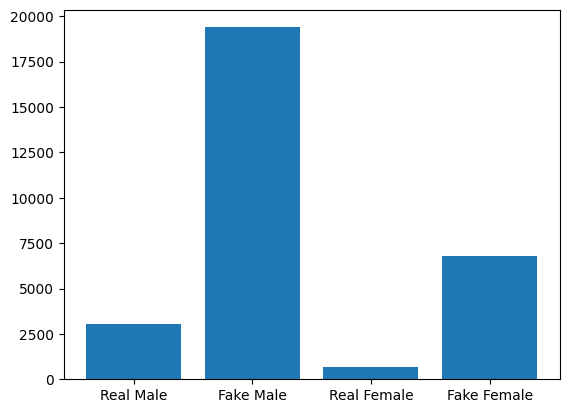

In [10]:
print(len(real_male_slices))
print(len(fake_male_slices))
print(len(real_female_slices))
print(len(fake_female_slices))
plt.bar(['Real Male', 'Fake Male', 'Real Female', 'Fake Female'], [len(real_male_slices), len(fake_male_slices), len(real_female_slices), len(fake_female_slices)])

In [11]:
#feature extraction and dataframe creation
sr = 22050
def extract_audio_features(files):
    features_list = []

    # Iterate over all files
    for y in files:
        # Extract features
        # Chromagram
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr).mean()

        # Root Mean Square Energy
        rms = librosa.feature.rms(y=y).mean()

        # Spectral Centroid
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()

        # Spectral Bandwidth
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()

        # Spectral Rolloff
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr).mean()

        # Zero Crossing Rate
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y).mean()

        # Mel-Frequency Cepstral Coefficients (MFCCs)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20).mean(axis=1)

        # Spectral Contrast
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr).mean()

        # Concatenate features as values for dataframe
        features = np.hstack((
            chroma_stft, rms, spectral_centroid, spectral_bandwidth, rolloff, zero_crossing_rate,
            mfccs, spectral_contrast
        ))

        features_list.append(features)

    # Create  DataFrame
    feature_names = [
        'chroma_stft', 'rms', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate'
    ] + [f'mfcc{i+1}' for i in range(mfccs.shape[0])] + ['spectral_contrast']

    df = pd.DataFrame(features_list, columns=feature_names)

    return df

##real +aumented audio features
features__male_real = extract_audio_features(real_male_slices)
features__male_fake = extract_audio_features(fake_male_slices)
features__female_real = extract_audio_features(real_female_slices)
features__female_fake = extract_audio_features(fake_female_slices)


In [12]:
print(features__male_real.shape)
print(features__male_fake.shape)
print(features__female_real.shape)
print(features__female_fake.shape)

(3063, 27)
(19389, 27)
(679, 27)
(6805, 27)


In [13]:
features__female_real["gender"] = 1
features__female_fake["gender"] =1
features__male_real["gender"] = 0
features__male_fake["gender"] =0
features__female_real["label"] = 1
features__female_fake["label"] =0
features__male_real["label"] = 0
features__male_fake["label"] =1
final_df = pd.concat([features__female_real,features__female_fake,features__male_real,features__male_fake],axis=0)
print(final_df.shape)

(29936, 29)


In [14]:
final_df.label.value_counts()

,count
label,
1,20068
0,9868


In [15]:
#splitting 80% data for training and rest 20 % for validation and testing
train_df, temp_df = train_test_split(final_df, test_size=0.20, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [16]:
#splitting in to independent and dependent variables
X = train_df.drop('label', axis=1)
y = train_df['label']
print(X.head())
print(y.head())

       chroma_stft       rms  spectral_centroid  spectral_bandwidth  \
6746      0.346965  0.068513        2079.270794         2428.633851   
6384      0.435346  0.013845        2810.256159         2162.900973   
19250     0.304455  0.065596        1689.920848         1866.188541   
17985     0.376733  0.058086        1704.068308         1736.019716   
743       0.430400  0.049233        2465.123441         2266.360641   

           rolloff  zero_crossing_rate       mfcc1       mfcc2      mfcc3  \
6746   3646.452193            0.099332 -203.317490  109.013107  13.222236   
6384   4900.761275            0.182573 -311.704376   48.360550 -68.372871   
19250  2895.237038            0.089145 -262.021515  123.332146  -9.880823   
17985  3022.478693            0.088201 -244.245987  138.857651 -26.246296   
743    4726.048695            0.121859 -260.297791   93.526131  -1.342766   

           mfcc4  ...     mfcc13     mfcc14     mfcc15    mfcc16    mfcc17  \
6746    8.077686  ...  -5.763774

In [20]:
X_val = val_df.drop(columns=['label'])
y_val = val_df['label']

In [17]:
random_forest = RandomForestClassifier(max_depth=None, n_estimators=200, random_state=42)
xgboost = XGBClassifier(learning_rate=0.2, max_depth=10, n_estimators=200, random_state=42)
lda = LinearDiscriminantAnalysis(solver='svd')
qda = QuadraticDiscriminantAnalysis(reg_param=0.0)


In [18]:
random_forest.fit(X, y)
xgboost.fit(X, y)
lda.fit(X, y)
qda.fit(X, y)

QuadraticDiscriminantAnalysis()

In [21]:
# Make predictions on validation set
y_val_pred_rf = random_forest.predict(X_val)
y_val_pred_xgb = xgboost.predict(X_val)
y_val_pred_lda = lda.predict(X_val)
y_val_pred_qda = qda.predict(X_val)

# Classification report for Random Forest
print("Random Forest:")
print(classification_report(y_val, y_val_pred_rf))

# Classification report for XGBoost
print("XGBoost:")
print(classification_report(y_val, y_val_pred_xgb))

# Classification report for LDA
print("LDA:")
print(classification_report(y_val, y_val_pred_lda))

# Classification report for QDA
print("QDA:")
print(classification_report(y_val, y_val_pred_qda))

Random Forest:
              precision    recall  f1-score   support

           0       0.97      0.90      0.94       992
           1       0.95      0.99      0.97      2002

    accuracy                           0.96      2994
   macro avg       0.96      0.95      0.95      2994
weighted avg       0.96      0.96      0.96      2994

XGBoost:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       992
           1       0.98      0.99      0.98      2002

    accuracy                           0.98      2994
   macro avg       0.98      0.97      0.97      2994
weighted avg       0.98      0.98      0.98      2994

LDA:
              precision    recall  f1-score   support

           0       0.93      0.73      0.81       992
           1       0.88      0.97      0.92      2002

    accuracy                           0.89      2994
   macro avg       0.90      0.85      0.87      2994
weighted avg       0.89      0.89      0.89  

In [22]:
# Analyze misclassifications for each gender
val_df['predicted_rf'] = y_val_pred_rf
val_df['predicted_xgb'] = y_val_pred_xgb
val_df['predicted_lda'] = y_val_pred_lda
val_df['predicted_qda'] = y_val_pred_qda

In [23]:
# Misclassified incidents
misclassified_rf = val_df[val_df['label'] != val_df['predicted_rf']]
misclassified_xgb = val_df[val_df['label'] != val_df['predicted_xgb']]
misclassified_lda = val_df[val_df['label'] != val_df['predicted_lda']]
misclassified_qda = val_df[val_df['label'] != val_df['predicted_qda']]

# Count misclassifications by gender
misclassified_by_gender_rf = misclassified_rf['gender'].value_counts()
misclassified_by_gender_xgb = misclassified_xgb['gender'].value_counts()
misclassified_by_gender_lda = misclassified_lda['gender'].value_counts()
misclassified_by_gender_qda = misclassified_qda['gender'].value_counts()

print("Misclassifications by Gender for Random Forest:")
print(misclassified_by_gender_rf)

print("Misclassifications by Gender for XGBoost:")
print(misclassified_by_gender_xgb)

print("Misclassifications by Gender for LDA:")
print(misclassified_by_gender_lda)

print("Misclassifications by Gender for QDA:")
print(misclassified_by_gender_qda)

Misclassifications by Gender for Random Forest:
gender
0    99
1    21
Name: count, dtype: int64
Misclassifications by Gender for XGBoost:
gender
0    58
1    12
Name: count, dtype: int64
Misclassifications by Gender for LDA:
gender
0    271
1     57
Name: count, dtype: int64
Misclassifications by Gender for QDA:
gender
0    189
1     57
Name: count, dtype: int64


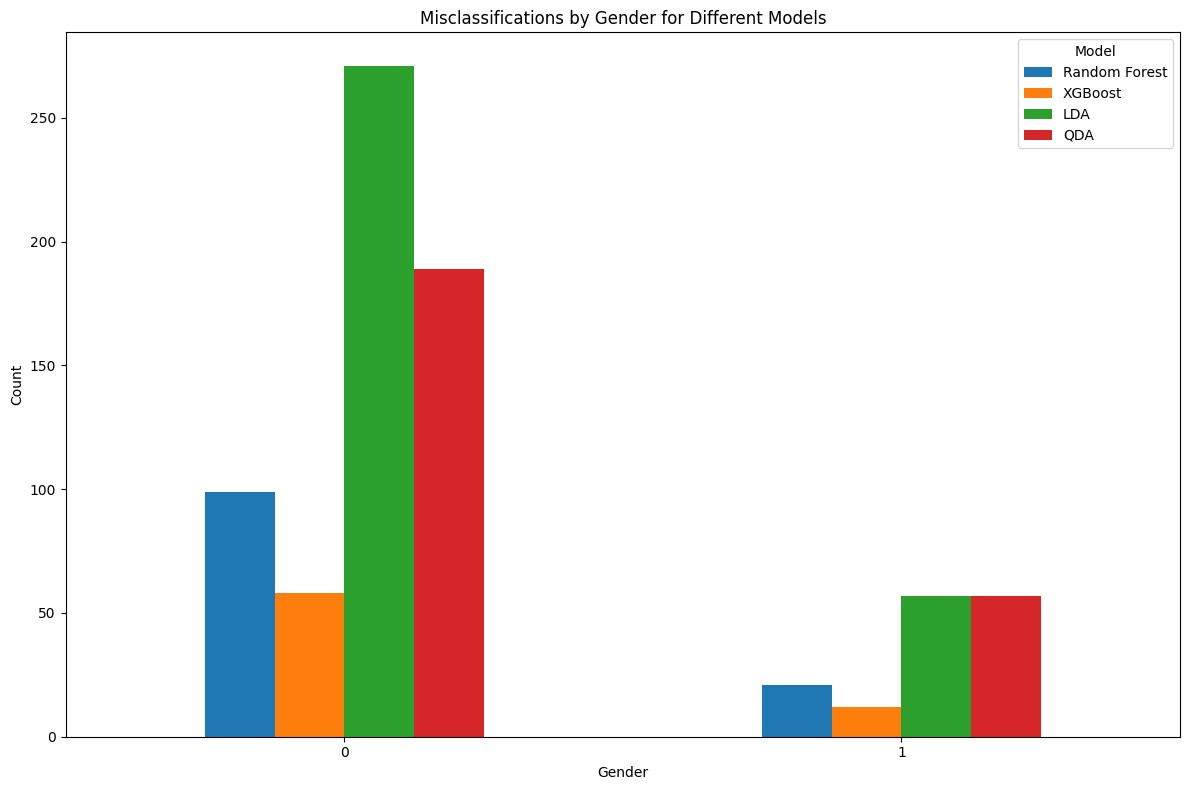

In [24]:
misclassified_df = pd.DataFrame({
    'Random Forest': misclassified_by_gender_rf,
    'XGBoost': misclassified_by_gender_xgb,
    'LDA': misclassified_by_gender_lda,
    'QDA': misclassified_by_gender_qda
})

# Plotting the combined misclassification data
ax = misclassified_df.plot(kind='bar', figsize=(12, 8))
plt.title('Misclassifications by Gender for Different Models')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Model')
plt.tight_layout()
plt.show()